# Problem Definition

## Supervised Learning Task
This project deals with multiclass image classification to identify the exact playing card (rank and suit) from an image. It's a supervised learning task where the model maps images to one of 52 classes.

## The 53 Classes
Classes combine 13 ranks (Ace, 2-10, Jack, Queen, King) and 4 suits (Clubs, Diamonds, Hearts, Spades), and a joker, giving 53 labels like "ace of clubs", "king of hearts".
Use-case includes automated card games, OCR for cards in apps, or educational tools.

## Expected Challenges
- Same rank, different suit: Cards like "ace of clubs" and "ace of spades" look almost the same except for suit marks.
- Lighting and angle: Images vary in brightness, angles, or blocks.
- Small details: Telling 8 from 9 needs focus on tiny features.
- Large data sets and classes 

# Dataset Creation & Preparation

I have downloaded the data set from the website kaggle, from the link [kaggle](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/data)

In this section, I have load the dataset from `cards.csv` and perform basic analysis.

The dataset is already made and labeled, with images saved locally. The CSV gives paths and labels, and splits are in the 'data set' column. i have checked all 53 classes have enough images. No missing files after filtering.

In [24]:
import pandas as pd

df = pd.read_csv("cards_dataset/cards.csv")
print("Dataset loaded successfully.")
print(f"Total images: {len(df)}")
print(f"Columns: {list(df.columns)}")

print(f"Unique labels: {len(df['labels'].unique())}")
print(f"Dataset splits: {df['data set'].unique()}")

class_counts = df['labels'].value_counts()
print("\nNumber of images per class:")
print(class_counts)

# Dataset size per split
split_counts = df['data set'].value_counts()
print(f"\nDataset sizes:\n{split_counts}")

Dataset loaded successfully.
Total images: 8155
Columns: ['class index', 'filepaths', 'labels', 'card type', 'data set']
Unique labels: 53
Dataset splits: ['train' 'test' 'valid']

Number of images per class:
labels
ace of spades        191
jack of spades       182
ace of hearts        181
jack of clubs        181
jack of hearts       178
seven of spades      175
queen of diamonds    173
queen of spades      172
queen of clubs       171
jack of diamonds     170
eight of diamonds    169
five of spades       168
ten of spades        168
six of spades        168
four of clubs        167
two of spades        165
two of hearts        165
four of hearts       164
nine of spades       164
three of diamonds    163
eight of hearts      162
six of clubs         162
ten of diamonds      161
king of spades       161
five of clubs        160
seven of hearts      153
three of spades      152
ten of clubs         151
four of spades       150
queen of hearts      149
six of diamonds      149
five of d

In [25]:
import os

df['exists'] = df['filepaths'].apply(lambda x: os.path.exists(os.path.join('cards_dataset', x)))
df = df[df['exists']]
print(f"After filtering missing files: {len(df)} images")

After filtering missing files: 8154 images


# Data Loading in fastai

I am using fastai's ImageDataLoaders.from_df to create DataLoaders from the CSV, following the DataBlock → DataLoaders abstraction from the lecture.

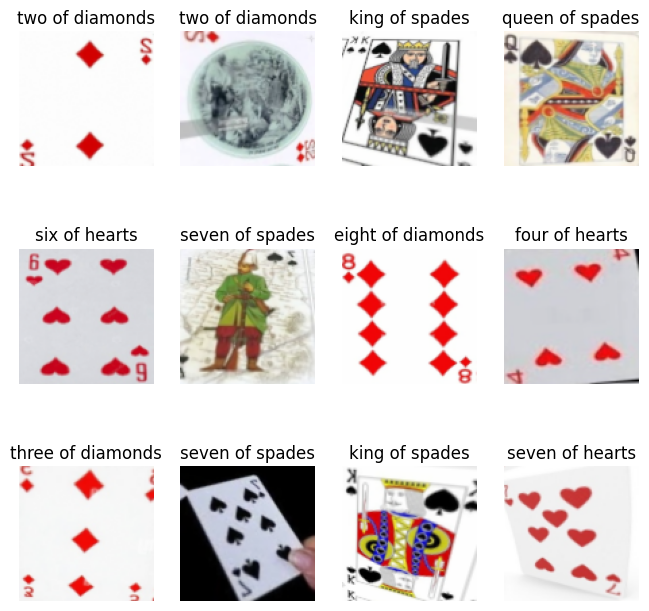

In [26]:
from fastai.vision.all import *

# Create DataLoaders from CSV
dls = ImageDataLoaders.from_df(
    df,
    path='cards_dataset',
    fn_col='filepaths',
    label_col='labels',
    splitter=ColSplitter(lambda x: x['data set'] == 'test'),
    item_tfms=Resize(100),
    batch_tfms=aug_transforms(mult=1.0),
    seed=42
)

# Show a batch of images
dls.show_batch(max_n=12, figsize=(8,8))

# Model Training (Transfer Learning)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Or/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 36.3MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,4.059643,2.759451,0.289571,01:40


epoch,train_loss,valid_loss,accuracy,time
0,2.740470,2.164963,0.414110,02:23
1,2.254610,1.823878,0.504908,02:19
2,1.774110,1.548842,0.590798,02:20
3,1.398668,1.332253,0.642945,02:24
4,1.143165,1.278590,0.654601,02:25
5,0.930627,1.180765,0.685276,02:25
6,0.766993,1.160385,0.695092,02:24
7,0.702140,1.155426,0.697546,02:25


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

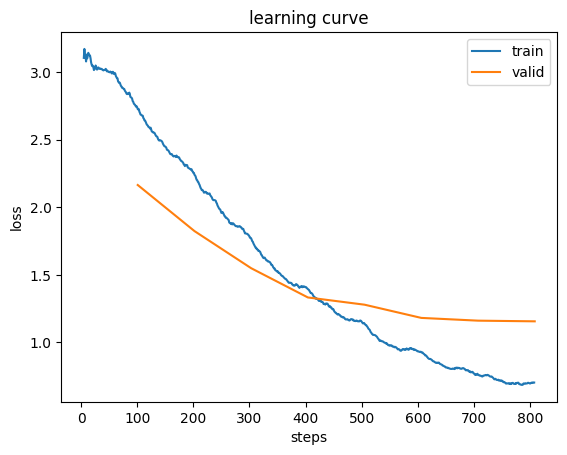

In [27]:
set_seed(42)
learn = vision_learner(
    dls,
    resnet18,
    metrics=accuracy
)
learn.fine_tune(8)
learn.recorder.plot_loss()

In [28]:
# Get final accuracy
final_loss, final_accuracy = learn.validate()
print(f"Final Validation Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

Final Validation Accuracy: 0.6975 (69.75%)


after research ResNet18 is chosen for faster training while maintaining good accuracy with 53 classes. Transfer learning uses weights from ImageNet, tuning the end for the task. Much better than starting from zero.

# Evaluation

I evaluated the model using ClassificationInterpretation to analyze performance.

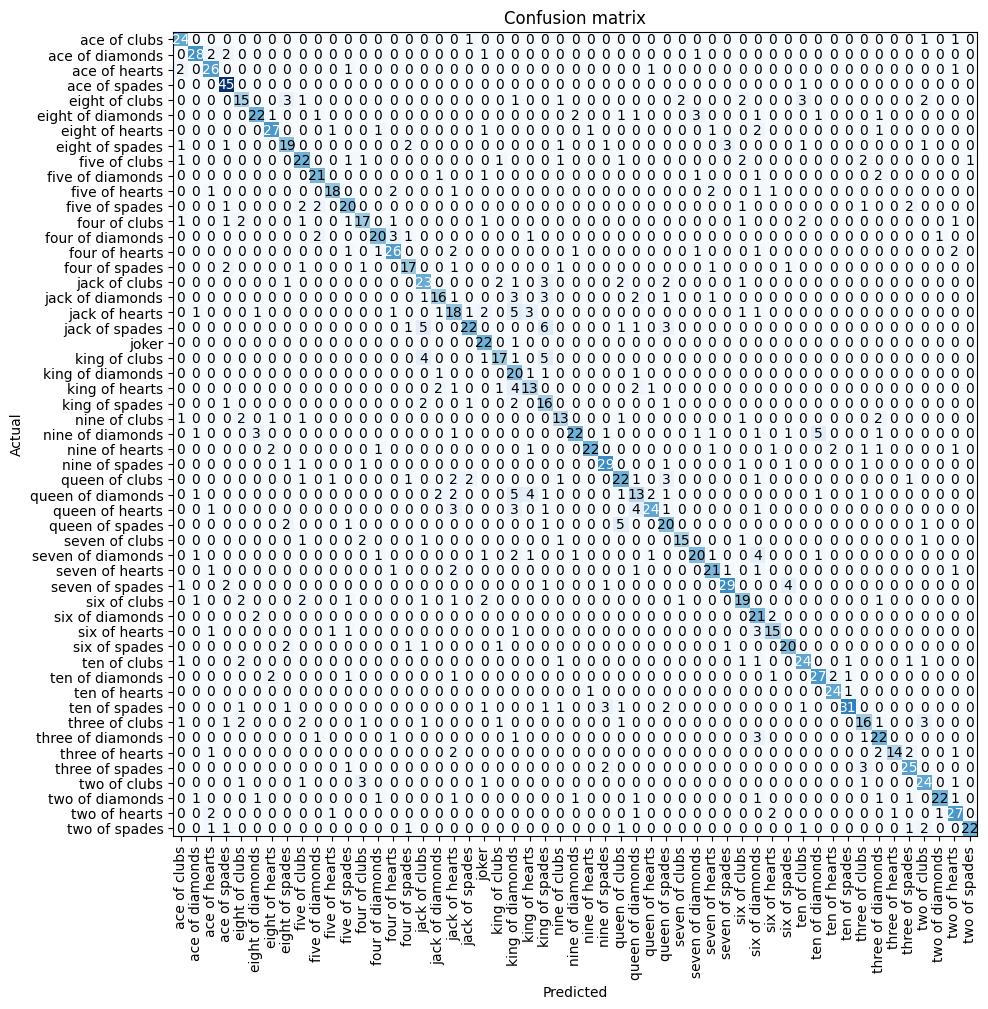

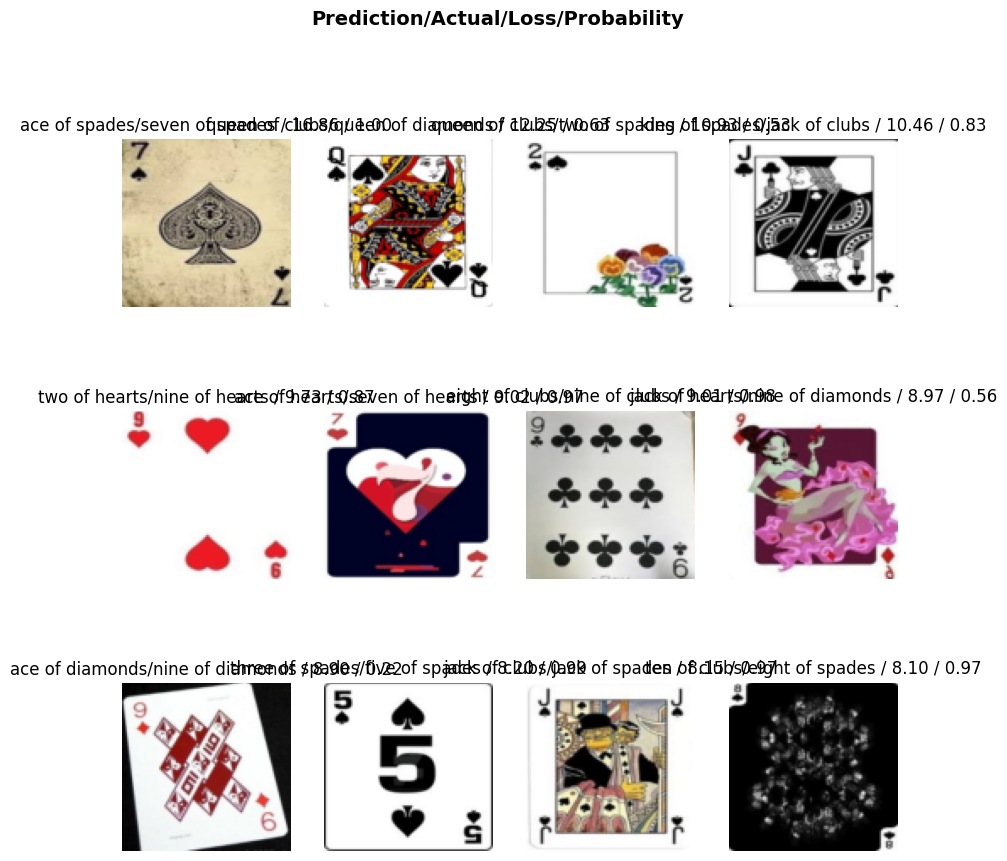

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.plot_top_losses(12, figsize=(10,10))

Common mistakes happen with same rank, different suit cards (e.g., "ace of clubs" seen as "ace of spades"), because they look so similar. Mistakes come from small suit differences, light changes, or hidden parts.

## Where the Model Struggles
The model has trouble with very similar cards, especially same rank, different suit. Also bad with poor images or weird angles.

## Dataset Limitations
The dataset varies a lot due to the many classes, requiring a lot of pictures for good learning. Because of that, training takes a long time.

## Improvements with More Time
- Get more varied data (different lights, angles, backgrounds)
- Use bigger images (e.g., 448x448)
- More data changes like turns and color shifts